In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import itertools

# Train-Validation_Test Dataset 

In [2]:
np.random.seed(1)
data = pd.read_csv('C:/Users/bahar/Documents/RA/Machine learning/kitsilano_east_1000.csv')

#data = data.drop(['clients_1', 'clients_2'], axis=1)

#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

data = pd.DataFrame(data)


# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)
print(data)
# Put data in tensor
inputs = torch.tensor( data.iloc[:, 0:8].values, dtype=torch.float32)
labels = torch.tensor(data.iloc[:, 8].values, dtype=torch.float32).unsqueeze(1)

print( labels.shape)

# Index training, validation, and test sets
n_train = int(0.6*len(data))
n_valid = int(0.2*len(data))
n_test  = len(data) - n_train - n_valid
train_idx = range(n_train)
valid_idx = range(n_train, n_train+n_valid)
test_idx  = range(n_train+n_valid, len(data))

# train, validation, and test sets
inputs_train = inputs[train_idx]
inputs_valid = inputs[valid_idx]
inputs_test  = inputs[test_idx]
labels_train = labels[train_idx]
labels_valid = labels[valid_idx]
labels_test  = labels[test_idx]

# TensorFlow 
train_data = TensorDataset(inputs_train, labels_train)
valid_data = TensorDataset(inputs_valid, labels_valid)
test_data = TensorDataset(inputs_test, labels_test)

print("Train:", len(train_data))
print("Valid:", len(valid_data))
print("Test:", len(test_data))

               0         1         2         3         4         5         6  \
0      -1.110460 -1.414707 -0.616330  0.009505  0.806753 -0.015931  0.141100   
1      -1.766894 -1.395270  0.125064 -1.477380  0.403101 -1.484313 -1.367014   
2       0.804565 -0.950317  1.548270  1.050878  0.823302  1.141456  0.542893   
3      -1.745985  0.093818 -1.002926 -0.341034  1.206572  0.933075 -0.987583   
4       0.817807  0.756915  1.548270  1.050878 -1.730762  1.265214  0.125064   
...          ...       ...       ...       ...       ...       ...       ...   
891131 -1.435730  1.247003  0.894488 -1.510681 -1.743110  0.482606 -1.651765   
891132  1.173395 -0.406251  1.548270  1.050878 -0.696425  1.205677  0.548495   
891133  1.206572  0.933075  1.295203 -0.460394  0.829803  1.546222  0.525538   
891134 -1.435730  1.247003  0.894488 -1.510681  1.181653 -1.517716  1.319030   
891135 -0.332850  0.034456  1.289150 -0.806390  0.062177  1.174639 -0.637324   

               7         8  
0      -0.

# Neural Network Architecture

In [3]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 5, 20)
    layers = []

    in_features = 8

    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 1, 100)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    
    return nn.Sequential(*layers)
def objective(trial):
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 30, 100)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

#    model = NeuralNetwork(input_dim, hidden_dim1, output_dim)
    model=define_model(trial)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
   
    for epoch in range(num_epochs):
        # Training
        train_running_loss = 0
        model.train()
        for train_inputs, train_label in train_dataloader:
            train_output = model(train_inputs)    
            train_loss = criterion(train_output, train_label) 
            optimizer.zero_grad()  
            train_loss.backward()
            optimizer.step()
            train_running_loss += train_loss.item()

        # Validation
        model.eval() 
        valid_running_loss = 0.0  
        with torch.no_grad():       
            for valid_inputs, valid_label in valid_dataloader:
                valid_output = model(valid_inputs)
                valid_loss = criterion(valid_output, valid_label)
                valid_running_loss += valid_loss.item()
        valid_loss = valid_running_loss / len(valid_dataloader)
 
        
    return valid_loss

# Cross Validation

In [4]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
                        

study.optimize(objective, n_trials=30)    
    
best_trial = study.best_trial
print('Best trial: ', best_trial.params)
print('Best trial value: ', best_trial.value)

[I 2023-06-12 08:06:46,483] A new study created in memory with name: no-name-3000113e-9223-47d1-aeb7-508bee8bad5e
C:\Users\moein16\AppData\Local\Temp\ipykernel_39848\3286688918.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-06-12 09:53:48,112] Trial 0 finished with value: 0.04174423232353046 and parameters: {'learning_rate': 0.001321496898091754, 'num_epochs': 74, 'batch_size': 16, 'n_layers': 8, 'n_units_l0': 20, 'n_units_l1': 21, 'n_units_l2': 66, 'n_units_l3': 83, 'n_units_l4': 31, 'n_units_l5': 21, 'n_units_l6': 47, 'n_units_l7': 37}. Best is trial 0 with value: 0.04174423232353046.
[I 2023-06-12 11:36:12,780] Trial 1 finished with value: 0.9988445902881973 and parameters: {'learning_rate': 0.019971387876302267, 'num_epochs': 95, 'batch_size

[I 2023-06-13 23:10:25,876] Trial 17 finished with value: 0.029508084452322978 and parameters: {'learning_rate': 0.00027280929900472283, 'num_epochs': 73, 'batch_size': 32, 'n_layers': 8, 'n_units_l0': 47, 'n_units_l1': 34, 'n_units_l2': 86, 'n_units_l3': 67, 'n_units_l4': 79, 'n_units_l5': 6, 'n_units_l6': 65, 'n_units_l7': 37}. Best is trial 5 with value: 0.02917707943783582.
[I 2023-06-14 01:12:49,820] Trial 18 finished with value: 0.9988651014744059 and parameters: {'learning_rate': 5.566892975368547e-05, 'num_epochs': 87, 'batch_size': 32, 'n_layers': 19, 'n_units_l0': 49, 'n_units_l1': 98, 'n_units_l2': 84, 'n_units_l3': 67, 'n_units_l4': 81, 'n_units_l5': 4, 'n_units_l6': 70, 'n_units_l7': 33, 'n_units_l8': 81, 'n_units_l9': 38, 'n_units_l10': 67, 'n_units_l11': 58, 'n_units_l12': 84, 'n_units_l13': 34, 'n_units_l14': 37, 'n_units_l15': 40, 'n_units_l16': 1, 'n_units_l17': 99, 'n_units_l18': 99}. Best is trial 5 with value: 0.02917707943783582.
[I 2023-06-14 01:57:14,265] Trial 

Best trial:  {'learning_rate': 7.442779192401252e-05, 'num_epochs': 98, 'batch_size': 16, 'n_layers': 17, 'n_units_l0': 71, 'n_units_l1': 74, 'n_units_l2': 78, 'n_units_l3': 77, 'n_units_l4': 63, 'n_units_l5': 64, 'n_units_l6': 82, 'n_units_l7': 25, 'n_units_l8': 57, 'n_units_l9': 74, 'n_units_l10': 52, 'n_units_l11': 47, 'n_units_l12': 19, 'n_units_l13': 41, 'n_units_l14': 23, 'n_units_l15': 26, 'n_units_l16': 91}
Best trial value:  0.02421481116112155


# Re-training

In [5]:
# Optimal hyperparameters
best_trial = study.best_trial
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
num_epochs = best_trial.params['num_epochs']

# Instance of the neural network
model = define_model(best_trial)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Retrain
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, label = data
        optimizer.zero_grad()    
        predictions = model(inputs)    
        loss = criterion(predictions, label)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    #if epoch % 10 == 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

Epoch [1/98], Loss: 0.2140
Epoch [2/98], Loss: 0.1244
Epoch [3/98], Loss: 0.0993
Epoch [4/98], Loss: 0.0859
Epoch [5/98], Loss: 0.0765
Epoch [6/98], Loss: 0.0696
Epoch [7/98], Loss: 0.0643
Epoch [8/98], Loss: 0.0603
Epoch [9/98], Loss: 0.0576
Epoch [10/98], Loss: 0.0547
Epoch [11/98], Loss: 0.0523
Epoch [12/98], Loss: 0.0504
Epoch [13/98], Loss: 0.0486
Epoch [14/98], Loss: 0.0469
Epoch [15/98], Loss: 0.0455
Epoch [16/98], Loss: 0.0440
Epoch [17/98], Loss: 0.0427
Epoch [18/98], Loss: 0.0416
Epoch [19/98], Loss: 0.0407
Epoch [20/98], Loss: 0.0397
Epoch [21/98], Loss: 0.0389
Epoch [22/98], Loss: 0.0380
Epoch [23/98], Loss: 0.0372
Epoch [24/98], Loss: 0.0364
Epoch [25/98], Loss: 0.0355
Epoch [26/98], Loss: 0.0350
Epoch [27/98], Loss: 0.0343
Epoch [28/98], Loss: 0.0336
Epoch [29/98], Loss: 0.0330
Epoch [30/98], Loss: 0.0325
Epoch [31/98], Loss: 0.0318
Epoch [32/98], Loss: 0.0313
Epoch [33/98], Loss: 0.0307
Epoch [34/98], Loss: 0.0306
Epoch [35/98], Loss: 0.0297
Epoch [36/98], Loss: 0.0296
E

# Evaluation on Test Set

In [30]:
test_dataloader = DataLoader(dataset=test_data, batch_size=5,shuffle=True)
model.state_dict()
model.eval() 

test_running_loss = 0.0  
with torch.no_grad():       
    for test_inputs, test_label in test_dataloader:
        test_output = model(test_inputs)
        test_loss= criterion(test_output, test_label)
        test_running_loss += test_loss.item()
    test_loss = test_running_loss / len(test_dataloader)
        
print(test_loss)

0.02403222986241199


# Prediction Error Visualization

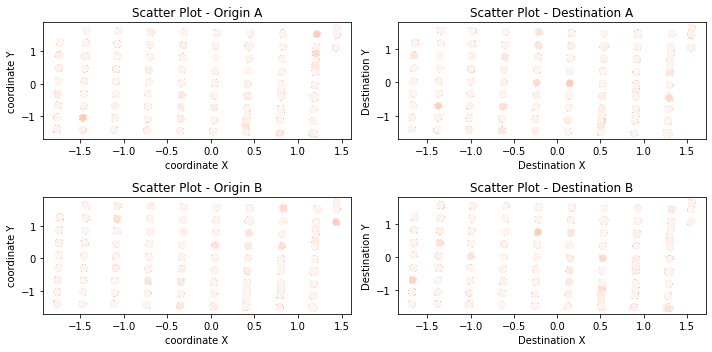

In [9]:
import matplotlib.cm as cm
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1)

prediction_errors = []
with torch.no_grad():

    for inputs, labels in test_dataloader:
        inputs = inputs.float()

        # prediction
        predicted_value = model(inputs)
        error = predicted_value - labels.item()
        prediction_errors.append(error)

#Passenger Coordinates 
Origin_A = []
Destination_A = []
Origin_B = []
Destination_B = []

for inputs, labels in test_dataloader:
 
    origin_A_subset = inputs[:, :2]
    destination_A_subset = inputs[:, 2:4]
    origin_B_subset = inputs[:, 4:6]
    destination_B_subset = inputs[:, 6:8]

    Origin_A.append(origin_A_subset)
    Destination_A.append(destination_A_subset)
    Origin_B.append(origin_B_subset)
    Destination_B.append(destination_B_subset)
    
prediction_errors=torch.cat(prediction_errors)
Origin_A = torch.cat(Origin_A)
Destination_A = torch.cat(Destination_A)
Origin_B = torch.cat(Origin_B)
Destination_B = torch.cat(Destination_B)

data_origin_A = pd.DataFrame(data=Origin_A.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_destination_A = pd.DataFrame(data=Destination_A.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_origin_A['Prediction_Error'] = abs(prediction_errors)
data_destination_A['Prediction_Error'] = abs(prediction_errors)

data_origin_B = pd.DataFrame(data=Origin_B.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_destination_B = pd.DataFrame(data=Destination_B.numpy(), columns=['coordinate_X', 'coordinate_Y'])
data_origin_B['Prediction_Error'] = abs(prediction_errors)
data_destination_B['Prediction_Error'] = abs(prediction_errors)


fig, axes = plt.subplots(2, 2, figsize=(10, 5))
cmap_originA = cm.get_cmap('Reds')
# Scatter plot for Origin

axes[0,0].scatter(data_origin_A['coordinate_X'], data_origin_A['coordinate_Y'], c=data_origin_A['Prediction_Error'],cmap=cmap_originA)
axes[0,0].set_xlabel('coordinate X')
axes[0,0].set_ylabel('coordinate Y')
axes[0,0].set_title('Scatter Plot - Origin A')


# Scatter plot for Destination

axes[0,1].scatter(data_destination_A['coordinate_X'], data_destination_A['coordinate_Y'],c=data_destination_A['Prediction_Error'] ,cmap=cmap_originA)
axes[0,1].set_xlabel('Destination X')
axes[0,1].set_ylabel('Destination Y')
axes[0,1].set_title('Scatter Plot - Destination A')


axes[1,0].scatter(data_origin_B['coordinate_X'], data_origin_B['coordinate_Y'],c=data_origin_B['Prediction_Error'] ,cmap=cmap_originA)
axes[1,0].set_xlabel('coordinate X')
axes[1,0].set_ylabel('coordinate Y')
axes[1,0].set_title('Scatter Plot - Origin B')

#marker_size_destinationB = [100 * err for err in data_destination_B['Prediction_Error']]
axes[1,1].scatter(data_destination_B['coordinate_X'], data_destination_B['coordinate_Y'], c=data_destination_B['Prediction_Error'] ,cmap=cmap_originA)
axes[1,1].set_xlabel('Destination X')
axes[1,1].set_ylabel('Destination Y')
axes[1,1].set_title('Scatter Plot - Destination B')


plt.tight_layout()


plt.show()


[-0.36826304  0.75415039  2.3713119  ...  1.94302249 -0.36826304
 -0.36826304]


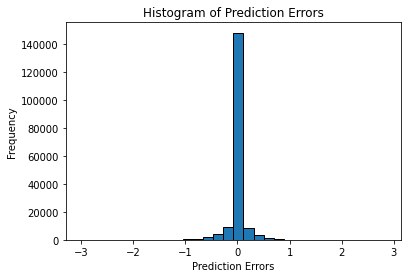

In [10]:
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1)

actual_labels = []
prediction_values = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        actual_labels.append(labels.item())

        # Perform prediction
        predicted_value = model(inputs)
        prediction_values.append(predicted_value.item())

actual_labels = np.array(actual_labels)
print(actual_labels)
prediction_values = np.array(prediction_values)

prediction_errors = prediction_values - actual_labels

bin=[0.25,0.5, 0.75, 0.9, 1, 1.2,1.8]
plt.hist(prediction_errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

4258


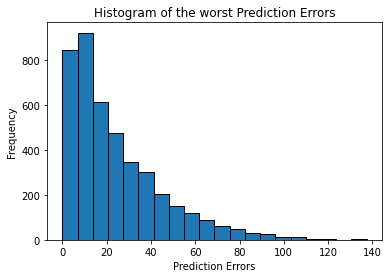

4258


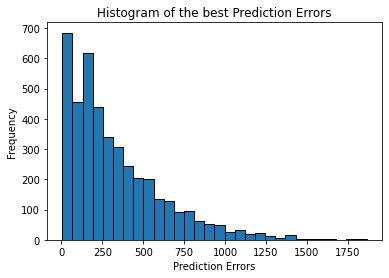

In [14]:

model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1)


actual_labels = []
prediction_values = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        actual_labels.append(labels.item())

        # Perform prediction
        predicted_value = model(inputs)
        prediction_values.append(predicted_value.item())

actual_labels = np.array(actual_labels)
#print(actual_labels)
prediction_values = np.array(prediction_values)

prediction_errors = prediction_values - actual_labels
#print(min(prediction_errors))

labels_with_high_errors = actual_labels[(prediction_errors > .5)| (prediction_errors < -.5)]
    #prediction_errors > 1]
labels_with_high_errors=(labels_with_high_errors*13.54224694)+4.987109038
print(len(labels_with_high_errors))

plt.hist(labels_with_high_errors, bins=20, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of the worst Prediction Errors')
plt.show()

labels_with_low_errors = actual_labels[(prediction_errors < 0.5)| (prediction_errors > -0.5)]
    #prediction_errors > 1]
labels_with_low_errors=(labels_with_high_errors*13.54224694)+4.987109038

print(len(labels_with_low_errors))

plt.hist(labels_with_low_errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of the best Prediction Errors')
plt.show()